In [2]:
import cv2
from urllib.request import urlretrieve

In [9]:
import cv2
import torch
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

def load_model():
  model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
  model.eval()
  return model

def make_transparent_foreground(pic, mask):
  # split the image into channels
  b, g, r = cv2.split(np.array(pic).astype('uint8'))
  # add an alpha channel with and fill all with transparent pixels (max 255)
  a = np.ones(mask.shape, dtype='uint8') * 255
  # merge the alpha channel back
  alpha_im = cv2.merge([b, g, r, a], 4)
  # create a transparent background
  bg = np.zeros(alpha_im.shape)
  # setup the new mask
  new_mask = np.stack([mask, mask, mask, mask], axis=2)
  # copy only the foreground color pixels from the original image where mask is set
  foreground = np.where(new_mask, alpha_im, bg).astype(np.uint8)

  return foreground

def remove_background(model, input_file):
  input_image = input_image = Image.open(input_file).convert("RGB")
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

  # move the input and model to GPU for speed if available
  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      model.to('cuda')

  with torch.no_grad():
      output = model(input_batch)['out'][0]
  output_predictions = output.argmax(0)

  # create a binary (black and white) mask of the profile foreground
  mask = output_predictions.byte().cpu().numpy()
  background = np.zeros(mask.shape)
  bin_mask = np.where(mask, 255, background).astype(np.uint8)

  foreground = make_transparent_foreground(input_image ,bin_mask)

  return foreground, bin_mask

Using cache found in C:\Users\Bhakti/.cache\torch\hub\pytorch_vision_v0.6.0


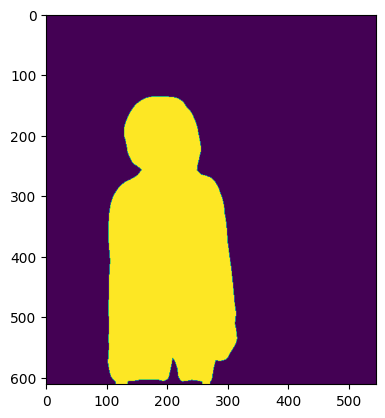

In [15]:
import numpy as np
deeplab_model = load_model()
foreground, bin_mask = remove_background(deeplab_model, 'me.png')
plt.imshow(bin_mask)

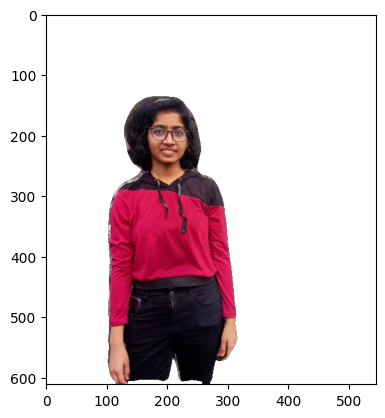

In [16]:
plt.imshow(foreground)

In [17]:
def custom_background(background_file, foreground):
  final_foreground = Image.fromarray(foreground)
  background = Image.open(background_file)
  x = (background.size[0]-final_foreground.size[0])/2
  y = (background.size[1]-final_foreground.size[1])/2
  box = (x, y, final_foreground.size[0] + x, final_foreground.size[1] + y)
  crop = background.crop(box)
  final_image = crop.copy()
  # put the foreground in the centre of the background
  paste_box = (0, final_image.size[1] - final_foreground.size[1], final_image.size[0], final_image.size[1])
  final_image.paste(final_foreground, paste_box, mask=final_foreground)
  return final_image

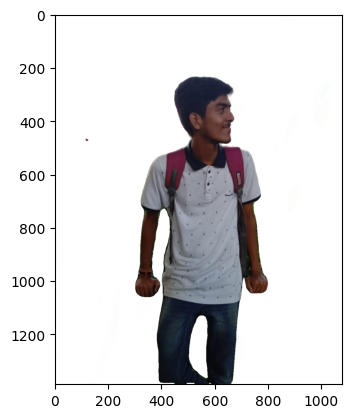

In [18]:
final_image = custom_background('/Users/eeshnaugraiya/Downloads/white-full-screen-portrait-e4y9uhig0nhpztcv.jpg', foreground)
plt.imshow(final_image)

In [9]:
final_image.save("/Users/eeshnaugraiya/Desktop/images/final.jpg")